In [1706]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1707]:
df = pd.read_csv('Data_test.csv',sep=";")

- **ToAfirst(ns)** = time stamp för mätningen eller tiden när partikel träffar detektor
- **x(pix),y(pix)** = x,y pos på detektorn (ungefär 200 pixlar på 8 cm)
- **Size** = storlek på spottarna
- **ToTsum** = Intensiteten (time over threshold)

### Sortera ToA

In [1708]:
df = df.sort_values(by=['ToAfirst(ns)'])

### Remove less than 7 px area and low intensity + Correct for distance to center


In [1709]:
### Sorting out
df = df[df['Size(Pix)'] >= 7]  
df = df[df['ToTsum(ns)'] > 15000]  

### Pixel to meter
df['X(m)'] = (df['X(pix)']-256/2)*0.0003
df['Y(m)'] = (df['Y(pix)']-256/2)*0.0003

### String to float
df['ToT@ToAfirst'] = pd.to_numeric(df['ToT@ToAfirst'], errors='coerce')

### Nanosec to sec
df['ToAfirst(ns)'] = (df['ToAfirst(ns)']) * 10 ** (-9)
df['ToTsum(ns)'] = (df['ToTsum(ns)']) * 10 ** (-9)
df['TDC_P_Edge(ns)'] = (df['TDC_P_Edge(ns)']) * 10 ** (-9)
df['ToT@ToAfirst'] = (df['ToT@ToAfirst']) * 10 ** (-9)
df['ToA@ToTmax'] = (df['ToA@ToTmax']) * 10 ** (-9)
df['ToTmax'] = (df['ToTmax']) * 10 ** (-9)

df.rename(columns= {'ToAfirst(ns)':'ToAfirst(s)','ToTsum(ns)':'ToTsum(s)','TDC_P_Edge(ns)':'TDC_P_Edge(s)','ToT@ToAfirst':'ToT@ToAfirst(s)','ToA@ToTmax':'ToA@ToTmax(s)','ToTmax':'ToTmax(s)'}, inplace = True)

### Define parameters

In [1710]:
L = 1.772 # meter
v = 331161.25 # m/s
J_eV = 6.24150907 * 10**18
amu = 1.66053907 * 10 ** (-27) #kilograms
m_C = 12 * amu
m_O = 15.994914619257 * amu

############ Three products different mass

#mass1 = 12 * amu # C
#ele_name_1 = 'C'

#mass2 = 15.994914619257 * amu # O
#ele_name_2 = 'O'

#mass3 = 15.994914619257 * amu # O
#ele_name_3 = 'O'

### Sort detections in events

In [1711]:
df['event'] = df['ToAfirst(s)'].diff().gt(200E-9).cumsum()

e = df['event'].value_counts()
df = df[df['event'].isin(e[e==3].index)]
xpix_lst = df['X(pix)'].tolist()


event_vals = []

for i in range(int(len(xpix_lst)/3)):
    event_vals.extend((i, i, i))


df['event'] = event_vals

### Plotta intensitet för coincidence events

fig = plt.figure()
ax = fig.add_subplot()
c = ax.hist(df['ToTsum(ns)'], 300)
ax.set(ylabel='#', xlabel='Intensity',
       title='Intensity histogram')
#ax.set_xlim([0,100000])
plt.show()

### Center of mass function

- **m1 = mC**
- **m2 = mO**

In [1712]:
def Center_mass_3(x1,x2,x3,y1,y2,y3,m1,m2,ele1,ele2):
    # function that returns the coordinates of the heavy neutral
    
    m_tot = m1+m2*2
   
    # m1 = m_C,
    # m2 = m_O,
    
    cm1_x = (x1 * m1 + x2 * m2 + x3 * m2) / m_tot # C-O-O
    cm1_y = (y1 * m1 + y2 * m2 + y3 * m2) / m_tot # C-O-O


    cm2_x = (x1 * m2 + x2 * m1 + x3 * m2) / m_tot # O-C-O
    cm2_y = (y1 * m2 + y2 * m1 + y3 * m2) / m_tot # O-C-O
    
    cm3_x = (x1 * m2 + x2 * m2 + x3 * m1) / m_tot # O-O-C
    cm3_y = (y1 * m2 + y2 * m2 + y3 * m1) / m_tot # O-O-C
    
    cm1 = np.sqrt(cm1_x**2 + cm1_y**2)
    cm2 = np.sqrt(cm2_x**2 + cm2_y**2)
    cm3 = np.sqrt(cm3_x**2 + cm3_y**2)
    
    cm_res = min(cm1, cm2, cm3)
    
    if cm_res == cm1:
        return cm1, cm1_x, cm1_y, m1, m2, m2, ele1, ele2, ele2
    elif cm_res == cm2:
        return cm2, cm2_x, cm2_y, m2, m1, m2, ele2, ele1, ele2
    else:
        return cm3, cm3_x, cm3_y, m2, m2, m1, ele2, ele2, ele1

def Center_mass_3_diff_mass(x1, x2, x3, y1, y2, y3, m1, m2, m3, ele1, ele2, ele3):
    # function that returns the coordinates of the heavy neutral
    
    m_tot = m1 + m2 + m3
   
    # m1 = m_C,
    # m2 = m_O,
    
    cm1_x = (x1 * m1 + x2 * m2 + x3 * m3) / m_tot # C-O-O
    cm1_y = (y1 * m1 + y2 * m2 + y3 * m3) / m_tot # C-O-O

    cm2_x = (x1 * m2 + x2 * m1 + x3 * m2) / m_tot # O-C-O
    cm2_y = (y1 * m2 + y2 * m1 + y3 * m2) / m_tot # O-C-O
    
    cm3_x = (x1 * m2 + x2 * m2 + x3 * m1) / m_tot # O-O-C
    cm3_y = (y1 * m2 + y2 * m2 + y3 * m1) / m_tot # O-O-C
    
    cm1 = np.sqrt(cm1_x**2 + cm1_y**2)
    cm2 = np.sqrt(cm2_x**2 + cm2_y**2)
    cm3 = np.sqrt(cm3_x**2 + cm3_y**2)
    
    cm_res = min(cm1, cm2, cm3)
    
    if cm_res == cm1:
        return cm1, cm1_x, cm1_y, m1, m2, m2, ele1, ele2, ele2
    elif cm_res == cm2:
        return cm2, cm2_x, cm2_y, m2, m1, m2, ele2, ele1, ele2
    else:
        return cm3, cm3_x, cm3_y, m2, m2, m1, ele2, ele2, ele1

### Beräkna lägsta C.m för varje event

- **m1 = mC**
- **m2 = mO**

In [1713]:
X_m = df['X(m)'].tolist()
Y_m = df['Y(m)'].tolist()

n = 0
#threshold = 0.5

cm_r_lst =[]
cm_x_lst = []
cm_y_lst = []

mass_lst=[]
name_lst=[]

while n <= len(X_m)-2:
    cmr, cmx, cmy, m_1, m_2, m_3, ele1, ele2, ele3 = Center_mass_3(X_m[n], X_m[n+1], X_m[n+2], Y_m[n], Y_m[n+1], Y_m[n+2], m_C, m_O, 'C', 'O')
    
    cm_r_lst.extend((cmr,cmr,cmr))      
    cm_x_lst.extend((cmx,cmx,cmx))   
    cm_y_lst.extend((cmy,cmy,cmy))   
    mass_lst.extend((m_1, m_2, m_3))
    name_lst.extend((ele1, ele2, ele3))
    
    n+=3

df['Mass(kg)'] = mass_lst
df['Molecule/Atom'] = name_lst
df['C.M X(m)'] = cm_x_lst
df['C.M Y(m)'] = cm_y_lst
df['C.M R(m)'] = cm_r_lst


### Z-position function

In [1714]:
def z_pos(m1, m2, m3, t1, t2, t3, v):
   
    M = m1 + m2 + m3

    t_M = (m1*t1 + m2*t2 + m3*t3)/M
    
    return v*(t1-t_M), v*(t2-t_M), v*(t3-t_M), t_M

### Output: Z distance from detector at time when c.m hits detector

In [1715]:

toa_z_lst = df['ToAfirst(s)'].tolist()
mass_z_lst = df['Mass(kg)'].tolist()
n = 0

Z_lst=[]
t_mean_single_lst=[]
t_mean_lst=[]

while n <= len(toa_z_lst)-2:
    z1, z2, z3, t_M = z_pos(mass_z_lst[n], mass_z_lst[n+1], mass_z_lst[n+2], toa_z_lst[n], toa_z_lst[n+1], toa_z_lst[n+2], v)
    
    Z_lst.extend((z1, z2, z3))
    t_mean_lst.extend((t_M, t_M, t_M))
    
    n+=3


df['T_mean(s)'] = t_mean_lst
df['Z_dist(m)'] = Z_lst


### 3D distace from CM


In [1716]:
def dist_center_mass(x, y, x_cm, y_cm, t_m, toa_z):
    
    return np.sqrt((x-x_cm)**2 + (y-y_cm)**2 + (v**2) * (t_m-toa_z) ** 2)

def dist_center_mass(x, y, x_cm, y_cm, t_m, toa_z):
    
    return np.sqrt(((x/toa_z)*t_m)**2 + ((y/toa_z)*t_m)**2 + (v**2) * (t_m-toa_z) ** 2)


In [1717]:
X_m = df['X(m)'].tolist()
Y_m = df['Y(m)'].tolist()

X_centm = df['C.M X(m)'].tolist()
Y_centm = df['C.M Y(m)'].tolist()

Z_centm = df['Z_dist(m)'].tolist()

time_mean_cm = df['T_mean(s)'].tolist()
toa = df['ToAfirst(s)'].tolist()

dist_to_CM =[]

for i in range(len(df['Z_dist(m)'])):
    r_dist_res = dist_center_mass(X_m[i], Y_m[i], X_centm[i], Y_centm[i], time_mean_cm[i], toa[i])
    dist_to_CM.append(r_dist_res)
    
df['Radial_CM_dist(m)'] = dist_to_CM

radial_disp =[]
for i in range(len(df['Mass (kg)'])):
    r_dist_res = dist_pix_m(X_pix_3[i],Y_pix_3[i], Z_lst[i])
    radial_disp.append(r_dist_res)

In [1718]:
def ang(x, y):
    return np.arctan(y/x)

In [1719]:
ang_lst=[]
X_dist_CM = df['C.M X(m)'].tolist()
Y_dist_CM = df['C.M Y(m)'].tolist()


for i in range(len(X_dist_CM)):
    ang_res = ang(X_dist_CM[i], Y_dist_CM[i])
    ang_lst.append(ang_res)
ang_lst = np.degrees(ang_lst)

fig = plt.figure()
ax = fig.add_subplot()
c = ax.scatter(X_dist_CM, Y_dist_CM, s=1)
ax.set(ylabel='', xlabel='',
       title='Center of mass positions on detector (m)')

ax.set_ylim([-.02,.02])
ax.set_xlim([-.02,.02])
plt.show()

### Center of mass position on detector before 

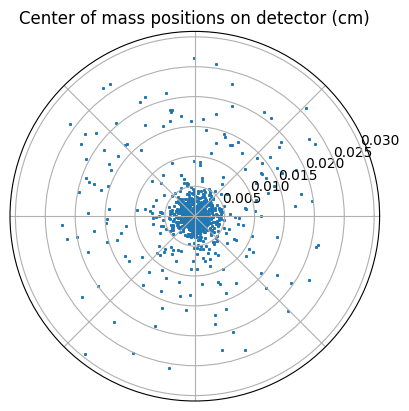

In [1720]:
R_dist_CM = df['C.M R(m)'].tolist()

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(ang_lst, R_dist_CM, s=1)
ax.set(ylabel='', xlabel='',
       title='Center of mass positions on detector (cm)', xticklabels=())

#ax.set_ylim([0, 3.75])
plt.show()

### After

In [1721]:
df = df[df['C.M R(m)'] < 0.005]  

ang_lst=[]
X_dist_CM = df['C.M X(m)'].tolist()
Y_dist_CM = df['C.M Y(m)'].tolist()

for i in range(len(X_dist_CM)):
    ang_res = ang(X_dist_CM[i], Y_dist_CM[i])
    ang_lst.append(ang_res)
ang_lst = np.degrees(ang_lst)

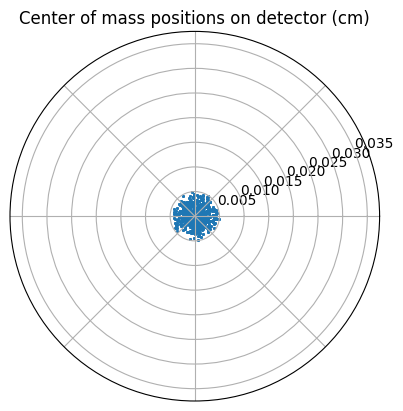

In [1722]:
R_dist_CM = df['C.M R(m)'].tolist()

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(ang_lst, R_dist_CM, s=1)
ax.set(ylabel='', xlabel='',
       title='Center of mass positions on detector (cm)', xticklabels=())

ax.set_ylim([0, 0.0375])
plt.show()

### Total displacement function

In [1723]:
def Total_dis(m1, m2, m3, r1, r2, r3, v, L):
    tot_mass = m1 + m2 + m3
    I_1 = m1*r1**2
    I_2 = m2*r2**2
    I_3 = m3*r3**2
    I_tot = I_1 + I_2 + I_3
    return np.sqrt(1/tot_mass * I_tot), ((v**2/(2*L**2))*I_tot)*J_eV

In [1724]:
mass_lst = df['Mass(kg)'].tolist()
radial_dist = df['Radial_CM_dist(m)'].tolist()

n = 0
TD_lst=[]
E_lst=[]

while n <= len(mass_lst)-2:
    TD_res, E_res = Total_dis(mass_lst[n], mass_lst[n+1], mass_lst[n+2], radial_dist[n], radial_dist[n+1], radial_dist[n+2], v, L)
   
    TD_lst.extend((TD_res, TD_res, TD_res))
    E_lst.extend((E_res, E_res, E_res))
    
    n+=3

df['Total displ(m)'] = TD_lst
df['Total E(eV)'] = E_lst

    

### Total displacement plot

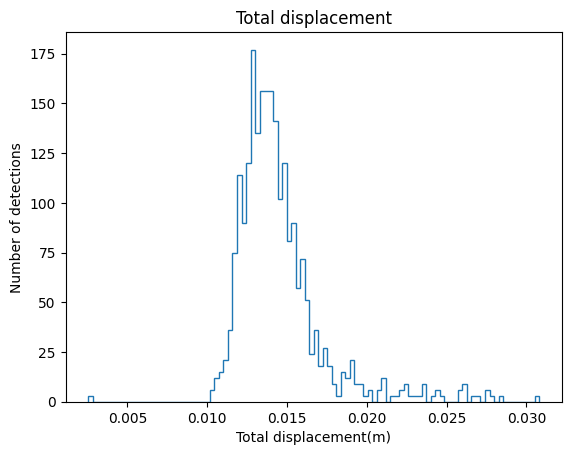

In [1725]:
TD_lst = df['Total displ(m)'].tolist()

fig = plt.figure()
ax = fig.add_subplot()
c = ax.hist(TD_lst, 100, histtype=u'step')
ax.set(ylabel='Number of detections', xlabel='Total displacement(m)',
       title='Total displacement')
plt.show()

### Energy

In [1726]:
def Energy(TD,m1,m2,m3,L,v):
    M = m1 + m2 + m3
    return (((TD * v)/L) ** 2 * M/2) * J_eV

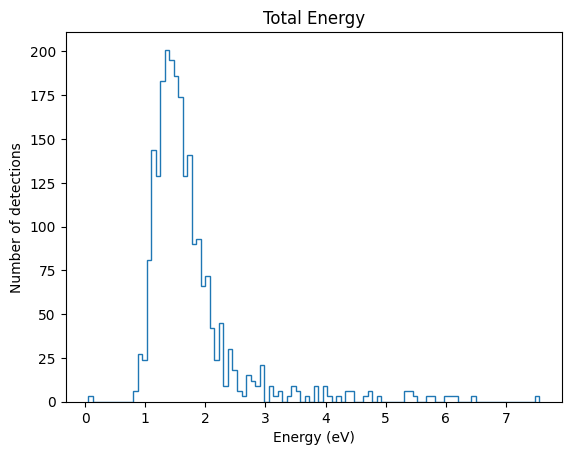

In [1727]:
E_lst = df['Total E(eV)']

fig = plt.figure()
ax = fig.add_subplot()
c = ax.hist(E_lst, 100, histtype=u'step')
ax.set(ylabel='Number of detections', xlabel='Energy (eV)',
       title='Total Energy')

plt.show()

In [1728]:
ToA_lst = df['ToAfirst(s)'].tolist()
TDC_lst = df['TDC_P_Edge(s)'].tolist()
TTD_lst = [ToA_lst[i] - TDC_lst[i] for i in range(len(ToA_lst))]
df['TTD(s)'] = TTD_lst

In [1729]:
TTD_lst = df['TTD(s)'].tolist()
thresh = 15

for n in range(1, len(TTD_lst)):
    
    if abs(TTD_lst[n]-TTD_lst[n - 1]) > thresh:
        TTD_lst[n] -= 26.8435456
# Constant : 26.8435456

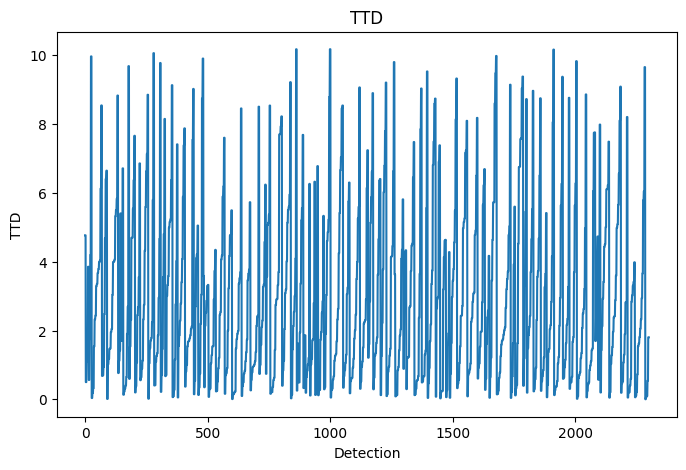

In [1730]:


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
c = ax.plot(TTD_lst)
ax.set(ylabel='TTD', xlabel='Detection',
       title='TTD')

plt.show()

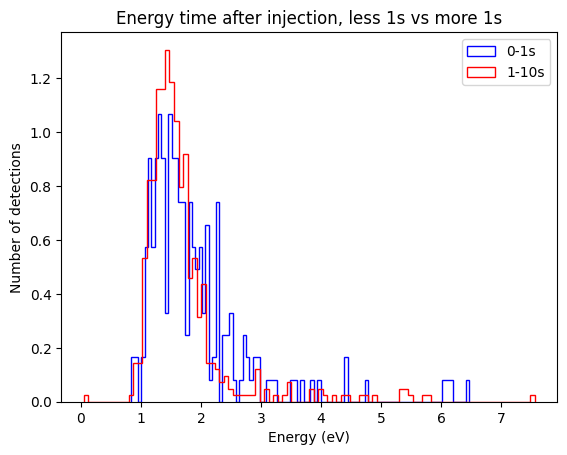

In [1731]:
E_lst = df['Total E(eV)'].tolist()
TTD_lst = df['TTD(s)'].tolist()

E_10 = 0
n = 0

E_less_1s_lst = []
E_more_1s_lst = []

while n < len(E_lst)-2:
    
    if TTD_lst[n]<1:
        E_less_1s_lst.append(E_lst[n])
    
    else: #TTD_lst[n]=>1:
        E_more_1s_lst.append(E_lst[n])
          
    n += 3
    
#########

fig = plt.figure()
ax = fig.add_subplot()
c = ax.hist(E_less_1s_lst, 100, histtype=u'step',color = 'b', density = True, label='0-1s')
b = ax.hist(E_more_1s_lst, 100, histtype=u'step',color = 'r', density = True, label='1-10s')
ax.set(ylabel='Number of detections', xlabel='Energy (eV)',
       title='Energy time after injection, less 1s vs more 1s')
ax.legend()

plt.show()

In [1732]:
def E_of_products(m, rad_dist, v, L):
    
    k = (m * v ** 2)/(2 * L ** 2)
    
    return (k * rad_dist ** 2) * J_eV

In [1733]:
mass_lst = df['Mass(kg)'].tolist()
rad_disp_lst = df['Radial_CM_dist(m)'].tolist()

n = 0
E_prod_lst=[]


while n < len(mass_lst):
    E_prod_res = E_of_products(mass_lst[n], rad_disp_lst[n], v, L)   
    E_prod_lst.append(E_prod_res)
    n+=1

df['Energy(eV)'] = E_prod_lst


In [1734]:
idx_C_lst = df.index[df['Molecule/Atom'] == 'C'].tolist()
C = df.loc[idx_C_lst]
E_prod_C = C['Energy(eV)'].tolist()  

idx_O_lst = df.index[df['Molecule/Atom'] == 'O'].tolist()
O = df.loc[idx_O_lst]
E_prod_O = O['Energy(eV)'].tolist()  

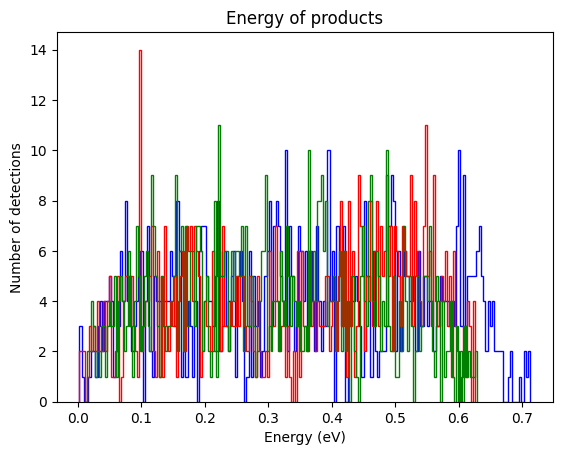

In [1735]:
E_lst = df['Total E(eV)']
fig = plt.figure()
ax = fig.add_subplot()

tot = [sum(x) for x in zip(E_prod_lst[0::3], E_prod_lst[1::3], E_prod_lst[2::3])]

#tot = E_prod_lst[0::3]+E_prod_lst[1::3]+E_prod_lst[2::3]

c = ax.hist(E_prod_C/E_lst[0::3], 200, histtype=u'step',color = 'b')
b = ax.hist(E_prod_O[0::2]/E_lst[0::3], 200, histtype=u'step',color = 'r')
a = ax.hist(E_prod_O[1::2]/E_lst[0::3], 200, histtype=u'step',color = 'g')
#d = ax.hist(tot, 200, histtype=u'step',color = 'y')
#e = ax.hist(E_lst[0::3], 200, histtype=u'step',color = 'k')

ax.set(ylabel='Number of detections', xlabel='Energy (eV)',
       title='Energy of products')

plt.show()
# Blå (C) borde vara ensam om att ha 0.72727 
# (O) max 0.63 

### Dali coordinate function

In [1736]:
import math

def dali_E_same_mass(E_1, E_2, E_3, m1, m2):
    
    M = m1 + m2 + m2
    E_sum = E_1 + E_2 + E_3
    
    return (math.sqrt(M/m1)*(E_3 - E_2))/(3 * E_sum), (((1+m1/m2)*E_1) - E_2 - E_3)/(3 * E_sum)

In [1737]:
import math

def dali_E_diff_mass(E_1, E_2, E_3, m1, m2):
    
    M = m1 + m2 + m2
    E_tot = E_1 + E_2 + E_3
    
    e_1 = (M * E_1) / (E_tot * (M - m1))
    e_2 = (M * E_2) / (E_tot * (M - m2))
    e_3 = (M * E_3) / (E_tot * (M - m3))
    
    a = ((M - m1)*(M - m2)*(M - m3))/(math.sqrt(m1 * m2 * m3 * M) * (M + m3))
    b = math.sqrt((M * m3) / (m1 * m2)) * ((m1 - m2) / (M + m3))
    
    return a * (e_1 - e_2) - b * e_3 - 1

### Calculating dali coordinates

In [1739]:
idx_C_lst = df.index[df['Molecule/Atom'] == 'C'].tolist()
C = df.loc[idx_C_lst]
E_prod_C = C['Energy(eV)'].tolist()  

idx_O_lst = df.index[df['Molecule/Atom'] == 'O'].tolist()
O = df.loc[idx_O_lst]
E_prod_O = O['Energy(eV)'].tolist()  

#df.index[df['Molecule/Atom'] == 'C'].tolist()
#E_prod_lst = df['Energy(eV)'].tolist()

n = 0
k = 0
dal_n1_coord = []
dal_n2_coord = []

while n < len(E_prod_C):
    
    n1, n2 = dali_E(E_prod_C[n], E_prod_O[k], E_prod_O[k+1], m_C, m_O)   
    
    dal_n1_coord.extend((n1, n1, n1))
    dal_n2_coord.extend((n2, n2, n2))
    
    n += 1
    k += 2

df['Dali n1'] = dal_n1_coord
df['Dali n2'] = dal_n2_coord

idx_C_lst = df.index[df['Molecule/Atom'] == 'C'].tolist()
C = df.loc[idx_C_lst]
E_prod_C = C['Energy(eV)'].tolist()  

idx_O_lst = df.index[df['Molecule/Atom'] == 'O'].tolist()
O = df.loc[idx_O_lst]
E_prod_O = O['Energy(eV)'].tolist()  

#df.index[df['Molecule/Atom'] == 'C'].tolist()
#E_prod_lst = df['Energy(eV)'].tolist()

n = 0
k = 0
dal_n1_coord_same=[]
dal_n2_coord_same=[]

dal_n1_coord_diff=[]
dal_n2_coord_diff=[]

while n < len(E_prod_C):
    
    n1_same, n2_same = dali_E(E_prod_C[n], E_prod_O[k], E_prod_O[k+1], m_C, m_O)   
    
    n1_diff, n2_diff = dali_E(E_prod_C[n], E_prod_O[k], E_prod_O[k+1], m_C, m_O)   
    
    dal_n1_coord_same.extend((n1_same, n1_same, n1_same))
    dal_n2_coord_same.extend((n2_same, n2_same, n2_same))
    
    dal_n1_coord_diff.extend((n1_diff, n1_diff, n1_diff))
    dal_n2_coord_diff.extend((n2_diff, n2_diff, n2_diff))
    
    
    n += 1
    k += 2

df['Dali n1 same'] = dal_n1_coord_same
df['Dali n2 same'] = dal_n2_coord_same

df['Dali n1 same'] = dal_n1_coord_diff
df['Dali n2 same'] = dal_n2_coord_diff

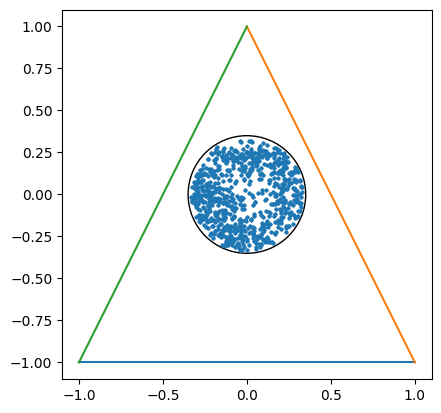

In [1740]:
dal_n1_lst = df['Dali n1'].tolist()
dal_n2_lst = df['Dali n2'].tolist()

circle1 = plt.Circle((0, 0), 0.35, color='k', fill=False)

plt.show()
fig = plt.figure()
ax = fig.add_subplot()
ax.add_patch(circle1)
ax.set_aspect('equal', 'box')
a = ax.scatter(dal_n1_lst, dal_n2_lst, s=3)

b = ax.plot([-1,1],[-1,-1])
c = ax.plot([1,0],[-1,1])
d = ax.plot([0,-1],[1,-1])


plt.show()
ax.set(xlabel='n1', ylabel='n2',
       title='Dalitz plot')
ax.set_xlim([-.4,.4])
ax.set_ylim([-.4,.4])


plt.show()

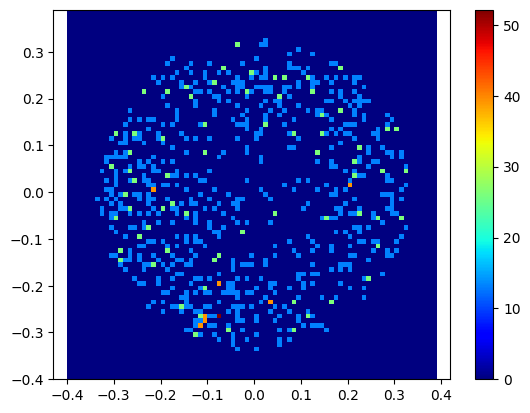

In [1741]:
dal_n1_lst = df['Dali n1'].tolist()
dal_n2_lst = df['Dali n2'].tolist()

fig, ax = plt.subplots()
#ax.hist2d(dal_n1_lst, dal_n2_lst, bins = (np.arange(-0.4, 0.4, 0.02), np.arange(-0.4, 0.4, 0.02)), density = True)
ax.axis('equal')
plt.hist2d(dal_n1_lst, dal_n2_lst, bins = (np.arange(-0.4, 0.4, 0.01), np.arange(-0.4, 0.4, 0.01)), cmap=plt.cm.jet, density = True)
plt.colorbar()
plt.show()